In [2]:
%%capture
!pip install datasets
!pip install evaluate

In [1]:
# imports
import os
import pandas as pd
import random
from datasets import Dataset, DatasetDict
import torch
import numpy as np

import pandas as pd
from datasets import Dataset
from transformers import BertTokenizer, BatchEncoding, T5Tokenizer, T5ForConditionalGeneration, MT5Tokenizer, MT5ForConditionalGeneration
from datasets import load_from_disk
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from transformers import BertForSequenceClassification
from sklearn.preprocessing import LabelEncoder

from torch.optim import AdamW
from transformers import get_scheduler
import evaluate
from torch.optim.lr_scheduler import ChainedScheduler, ExponentialLR

from tqdm.auto import tqdm
from google.colab import files

In [2]:
# Connet to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Create_augmentations.py

In [3]:
import os.path
import pandas as pd
import random
from datasets import Dataset
import torch
import numpy as np

def random_replace(string, default_prob):
    drop_prob = default_prob / 6
    space_prob = default_prob / 6
    replacements = {
        'א': [('ע', default_prob), ('ה', default_prob)],
        'ע': [('א', default_prob), ('ה', default_prob)],
        'ה': [('א', default_prob), ('ע', default_prob)],

        'ט': [('ת', default_prob)],
        'ת': [('ט', default_prob)],

        'ח': [('כ', default_prob)],
        'כ': [('ח', default_prob), ('ק', default_prob)],
        'ק': [('כ', default_prob)],

        'ש': [('ס', default_prob / 2)],
        'ס': [('ש', default_prob / 2)],

        'ב': [('ו', default_prob / 4)],
        'ו': [('ב', default_prob / 4)],

        'ג': [('ז', default_prob / 4)],
        'ז': [('ג', default_prob / 4)]
    }

    # Convert string to list to make replacements
    string_list = list(string)
    previous_was_changed = False  # we avoid dropping a few letters in a row
    for idx, char in enumerate(string_list):
        if char in replacements:
            for replacement, prob in replacements[char]:
                if random.random() < prob:  # Unique probability for each replacement
                    string_list[idx] = replacement
                    previous_was_changed = True
                    break  # Stop after the first replacement
        if previous_was_changed is False and (random.random() < drop_prob):  # Randomly decide to drop a letter
            string_list[idx] = ''

    new_string_list = []
    previous_was_dropped = False  # we avoid dropping a few letters in a row
    for char in string_list:
        new_string_list.append(char)
        if (previous_was_dropped is False) and (random.random() < space_prob):  # Randomly decide to add a space
            new_string_list.append(' ')
            previous_was_dropped = True
            continue
        previous_was_dropped = False

    return ''.join(new_string_list)


def create_augmentations(data_dir, percentage=20, verbose=False, truncate_min=1, truncate_max=13, duplicate_num=1):
    default_prob = float(percentage) / 100

    input_txt_path = data_dir + 'hebrew_text.txt'
    output_path = data_dir + 'hebrew_text_aug_' + str(percentage)

    # Read the input TXT file
    with open(input_txt_path, 'r', encoding='utf-8') as infile:
        lines = infile.readlines()

    # Process each line
    processed_lines = [lines[0]]
    for long_line in lines[1:]:
        long_line = long_line.strip()
        if truncate_min is None or truncate_max is None:
            current_lines = [long_line]
        else:
            words = long_line.split()
            current_lines = []
            num_words = np.random.randint(truncate_min, truncate_max)
            for i in range(duplicate_num):
              current_lines.append(' '.join(words[:num_words]))
        for line in current_lines:
            modified_line = random_replace(line, default_prob)
            if line == '' or len(line) < 2:
                continue
            processed_lines.append(f"{line}\t{modified_line}")

    if verbose:
        print(f'-----------> Example:\n\n')
        print(processed_lines[1])
        print(f'<-----------= Example:\n\n')

    print(f'Exporting the data to Excel file...')
    print(f'{len(processed_lines)-1} lines.')

    processed_lines = processed_lines[1:]
    data = [line.strip().split('\t') for line in processed_lines]
    df = pd.DataFrame(data, columns=['original', 'errors'])  # Adjust column names as needed
    excel_output_path = output_path + '.xlsx'
    df.to_excel(excel_output_path, index=False, engine='openpyxl')

    print(f"Conversion complete. Check {excel_output_path}")
    return excel_output_path


def export_dataset(excel_path):
    df = pd.read_excel(excel_path)
    df.dropna(subset=['errors', 'original'], inplace=True)
    texts_with_errors = df['errors'].tolist()
    texts_corrected = df['original'].tolist()

    data_dict = {
        'errors': texts_with_errors,
        'original': texts_corrected
    }

    # dataset = ds.Dataset.from_dict(data_dict)
    dataset = Dataset.from_dict(data_dict)

    return dataset

def create_or_load_dataset(data_dir, augemntation_percentage=30, test_size=0.2, verbose=False, duplicate_num=1, force_create=False):
    train_path = data_dir + 'train.pt'
    test_path = data_dir + 'test.pt'
    if (not os.path.exists(train_path)) or (not os.path.exists(test_path)) or force_create:
        print('Creating & Saving Dataset...')
        excel_path = create_augmentations(data_dir, augemntation_percentage, verbose, duplicate_num=duplicate_num)
        dataset = export_dataset(excel_path)
        # Split the dataset into training and testing sets
        train_test_split = dataset.train_test_split(test_size=test_size)
        torch.save(train_test_split['train'], train_path)
        torch.save(train_test_split['test'], test_path)
        return train_test_split['train'], train_test_split['test']
    else:
        print('Loading Dataset from file...')
        train_split = torch.load(train_path)
        test_split = torch.load(test_path)
        return train_split, test_split


# transformer_prepare_data.py

In [10]:
from transformers import BatchEncoding, MT5Tokenizer, MT5ForConditionalGeneration
import torch
from torch.utils.data import DataLoader

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# --------- HELPER FUNCTIONS -----------
# -------------------------------------->
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items() if key in ['input_ids', 'attention_mask']}
        # Ensure labels are correctly indexed
        if isinstance(self.labels, BatchEncoding):
            item['labels'] = self.labels['input_ids'][idx]  # Adjust according to how labels are stored
        else:
            item['labels'] = self.labels[idx].clone().detach()

        return item

    def __len__(self):
        # return len(self.labels)
        return len(self.encodings['input_ids'])

def get_model():
    model_name = "google/mt5-small"
    tokenizer = MT5Tokenizer.from_pretrained(model_name)
    model = MT5ForConditionalGeneration.from_pretrained(model_name)

    # --------- FREEZING LAYERS ------------
    # -------------------------------------->

    # for name, param in model.named_parameters():
    #     if name.startswith("encoder.block.2."):
    #         param.requires_grad = False

    # for name, param in model.named_parameters():
    #     if name.startswith("encoder.block.3."):
    #         param.requires_grad = False

    # for name, param in model.named_parameters():
    #     if name.startswith("encoder.block.4."):
    #         param.requires_grad = False

    for name, param in model.named_parameters():
        if name.startswith("encoder.block.5."):
            param.requires_grad = False

    for name, param in model.named_parameters():
        if name.startswith("encoder.block.6."):
            param.requires_grad = False

    for name, param in model.named_parameters():
        if name.startswith("encoder.block.7."):
            param.requires_grad = False

    for name, param in model.named_parameters():
        if name.startswith("decoder.block.0."):
            param.requires_grad = False

    for name, param in model.named_parameters():
        if name.startswith("decoder.block.1."):
            param.requires_grad = False

    for name, param in model.named_parameters():
        if name.startswith("decoder.block.2."):
            param.requires_grad = False

    for name, param in model.named_parameters():
        if name.startswith("decoder.block.3."):
            param.requires_grad = False

    for name, param in model.named_parameters():
        if name.startswith("decoder.block.4."):
            param.requires_grad = False

    for name, param in model.named_parameters():
        if name.startswith("decoder.block.5."):
            param.requires_grad = False

    # for name, param in model.named_parameters():
    #     if name.startswith("decoder.block.6."):
    #         param.requires_grad = False

    # <--------------------------------------

    # ----------SEEING THE MODEL------------
    # -------------------------------------->
    print()
    print('--- Printing the layers of the model ---')
    for name, param in model.named_parameters():
        print(name, param.requires_grad)
    print('--- Done printing the layers of the model ---')
    print()

    # <--------------------------------------
    return model, tokenizer

def prepare_one_dataset(ds, tokenizer, num_samples, max_length = 128, X_NAME='errors', Y_NAME='original'):
    ds.set_format('pytorch')
    inputs = ds[X_NAME]
    labels = ds[Y_NAME]
    if num_samples is not None and num_samples > 0:
      inputs = inputs[:num_samples]
      labels = labels[:num_samples]
    input_tokenized = tokenizer(inputs, truncation=True, padding=True, max_length=max_length,
                                      return_tensors='pt')
    labels_tokenized = tokenizer(labels, truncation=True, padding=True, max_length=max_length,
                                       return_tensors='pt')
    return TextDataset(input_tokenized, labels_tokenized)

def prepare_data(data_dir, tokenizer, augemntation_percentage=30, test_size=0.2, num_train=None, num_test=None, max_length = 128, X_NAME='errors', Y_NAME='original'):
    # -------------- DATASET ---------------
    # -------------------------------------->
    dataset_train, dataset_test = create_or_load_dataset(data_dir, augemntation_percentage=augemntation_percentage, test_size=test_size, verbose=False)
    return (prepare_one_dataset(dataset_train, tokenizer, num_train, max_length, X_NAME, Y_NAME),
            prepare_one_dataset(dataset_test, tokenizer, num_test, max_length, X_NAME, Y_NAME))

def get_model_and_data(data_dir, num_train=None, num_test=None):
    model, tokenizer = get_model()
    text_tensor_train_ds, text_tensor_test_ds = prepare_data(data_dir, tokenizer, num_train, num_test)

    return model, tokenizer, text_tensor_train_ds, text_tensor_test_ds

# transformer.py

In [6]:
import os
import random

import evaluate
import torch
from torch.optim.lr_scheduler import ChainedScheduler, ExponentialLR
from torch.utils.data import DataLoader
from transformers import Adafactor, get_cosine_schedule_with_warmup
from tqdm.auto import tqdm

def is_running_in_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_running_in_colab():
    from google.colab import drive
    drive.mount('/content/drive')
    data_dir = "drive/MyDrive/HHSC/"
else:
    data_dir = 'datasets/'

# ---------- HYPERPARAMETERS -----------
# -------------------------------------->
BATCH_SIZE = 16
num_epochs = 15
num_train = None
num_test = 1000
lr = 1e-3
accumulation_steps = 4
# <--------------------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set seed for consistency
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Load the saved datasets
model, tokenizer, text_tensor_train_ds, text_tensor_test_ds = get_model_and_data(data_dir, num_train=num_train, num_test=num_test)
model.to(device)

# Create DataLoaders
train_dataloader = DataLoader(text_tensor_train_ds, shuffle=True, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(text_tensor_test_ds, batch_size=BATCH_SIZE)

num_training_steps = num_epochs * len(train_dataloader)
optimizer = Adafactor(model.parameters(), scale_parameter=False, relative_step=False, warmup_init=False, lr=lr)
cosine_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=100,
    num_training_steps=num_training_steps
)
exp_scheduler = ExponentialLR(optimizer, gamma=0.9)
lr_scheduler = ChainedScheduler([cosine_scheduler, exp_scheduler])
scaler = torch.cuda.amp.GradScaler()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]


--- Printing the layers of the model ---
shared.weight True
encoder.block.0.layer.0.SelfAttention.q.weight True
encoder.block.0.layer.0.SelfAttention.k.weight True
encoder.block.0.layer.0.SelfAttention.v.weight True
encoder.block.0.layer.0.SelfAttention.o.weight True
encoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight True
encoder.block.0.layer.0.layer_norm.weight True
encoder.block.0.layer.1.DenseReluDense.wi_0.weight True
encoder.block.0.layer.1.DenseReluDense.wi_1.weight True
encoder.block.0.layer.1.DenseReluDense.wo.weight True
encoder.block.0.layer.1.layer_norm.weight True
encoder.block.1.layer.0.SelfAttention.q.weight True
encoder.block.1.layer.0.SelfAttention.k.weight True
encoder.block.1.layer.0.SelfAttention.v.weight True
encoder.block.1.layer.0.SelfAttention.o.weight True
encoder.block.1.layer.0.layer_norm.weight True
encoder.block.1.layer.1.DenseReluDense.wi_0.weight True
encoder.block.1.layer.1.DenseReluDense.wi_1.weight True
encoder.block.1.layer.1.DenseR

In [7]:
progress_bar = tqdm(range(num_training_steps))

def calc_accuracy(model, tokenizer, test_dataloader):
    metric = evaluate.load("accuracy")
    model.eval()  # Set the model to evaluation mode
    total_loss = 0

    with torch.no_grad():  # Disable gradient calculation for efficiency
        for batch in test_dataloader:
            batch = {key: value.to(device) for key, value in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()

            # Generate predictions
            generated_tokens = model.generate(batch['input_ids'], max_length=batch['labels'].shape[1])

            # Calculate accuracy by comparing generated texts to target texts
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            predictions = predictions.view(-1)
            references = batch["labels"].view(-1)
            mask = references != tokenizer.pad_token_id
            predictions = predictions[mask]
            references = references[mask]

            metric.add_batch(predictions=predictions, references=references)

    avg_test_loss = total_loss / len(test_dataloader)
    accuracy_dict = metric.compute()
    accuracy = float(accuracy_dict['accuracy'])
    random_index = random.randint(0, len(batch['labels']) - 1)
    random_target = tokenizer.decode(batch['labels'][random_index], skip_special_tokens=True)
    random_prediction = tokenizer.decode(generated_tokens[random_index], skip_special_tokens=True)
    random_current = tokenizer.decode(batch['input_ids'][random_index], skip_special_tokens=True)
    print(f'Input: {random_current}\nTarget: {random_target}\nPrediction: {random_prediction}')

    model.train()  # Set the model back to training mode
    return avg_test_loss, accuracy

saved_checkpoint_path = '/content/drive/My Drive/saved_checkpoint1.pth'
if os.path.exists(saved_checkpoint_path):
  checkpoint = torch.load(saved_checkpoint_path)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  scaler.load_state_dict(checkpoint['scaler_state_dict'])
  lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
  start_epoch = checkpoint['epoch'] + 1
  best_accuracy = checkpoint['best_accuracy']
  print('Model loaded from Google Drive')
else:
  start_epoch = 0
  best_accuracy = 0

model.train()
train_losses = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(start_epoch):
  for batch in train_dataloader:
        progress_bar.update(1)
for epoch in range(start_epoch, num_epochs):
    epoch_loss = 0
    for batch_idx, batch in enumerate(train_dataloader):
        batch = {key: value.to(device) for key, value in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss

        # Backward pass
        loss.backward()

        # Update weights and reset gradients every 'accumulation_steps'
        if (batch_idx + 1) % accumulation_steps == 0:
          optimizer.step()
          lr_scheduler.step()
          optimizer.zero_grad()

        progress_bar.update(1)

        epoch_loss += loss.item()  # Accumulate the loss

    # Calculate average loss for the epoch
    avg_train_loss = epoch_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"\nEpoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}")

    # -------------------------------------------
    model.eval()
    avg_test_loss, accuracy = calc_accuracy(model, tokenizer, test_dataloader)
    test_losses.append(avg_test_loss)
    test_accuracies.append(accuracy)
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {accuracy:.4f}  learning reate: {optimizer.param_groups[0]['lr']}")
    # Set the model back to training mode
    model.train()
    # -------------------------------------------

    # Saving checkout
    if accuracy > best_accuracy:
      best_accuracy = accuracy
      #torch.save(model.state_dict(), 'saved_model_checkout.pth')
      # Save the model to your Google Drive
      torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scaler_state_dict': scaler.state_dict(),  # if using mixed precision
            'scheduler_state_dict': lr_scheduler.state_dict(),
            'best_accuracy': best_accuracy,
      }, saved_checkpoint_path)

torch.save(model.state_dict(), 'saved_model1.pth')

  0%|          | 0/54540 [00:00<?, ?it/s]

Model loaded from Google Drive

Epoch 14/15, Training Loss: 0.1298


Input: יש ל טאם מ שובח על
Target: יש לך טעם משובח על
Prediction: יש לתהום משובח על
Test Loss: 0.0793, Test Accuracy: 0.9536  learning reate: 0.0007857440706576868

Epoch 15/15, Training Loss: 0.1060
Input: אם היא עלוהים בא
Target: אם היה אלוהים בא
Prediction: אם היה אלוהים בא
Test Loss: 0.0542, Test Accuracy: 0.9677  learning reate: 0.0007695722464390503


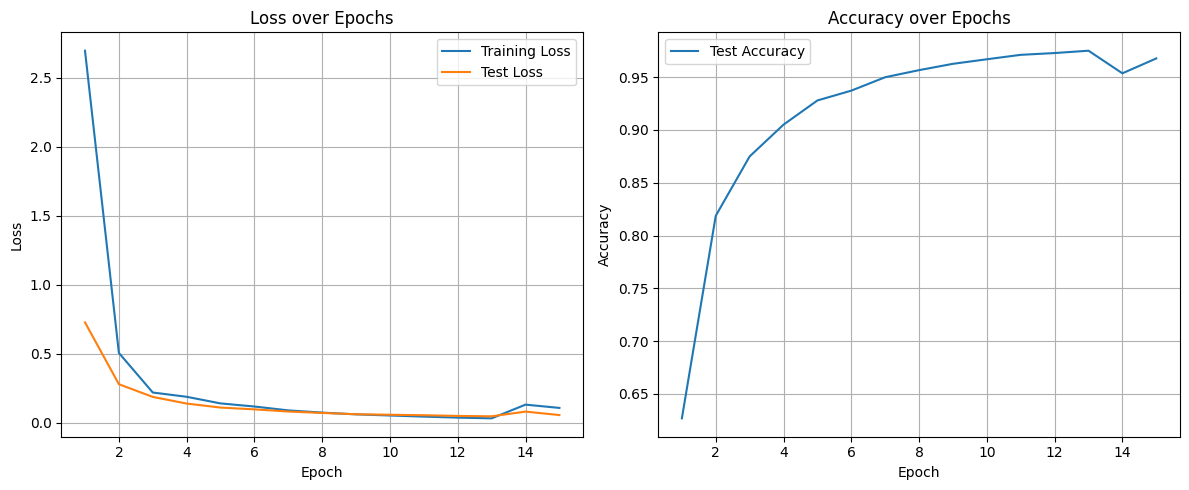

In [12]:
"""
model, tokenizer = get_model()

saved_checkpoint_path = '/content/drive/My Drive/saved_checkpoint1.pth'
checkpoint = torch.load(saved_checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
start_epoch = checkpoint['epoch'] + 1
best_accuracy = checkpoint['best_accuracy']
print('Model loaded from Google Drive')
"""
"""
Epoch 1/15, Training Loss: 2.6974
Test Loss: 0.7265, Test Accuracy: 0.6269  learning reate: 0.0008995096974038667

Epoch 2/15, Training Loss: 0.5050
Test Loss: 0.2780, Test Accuracy: 0.8187  learning reate: 0.0008977902833070186

Epoch 3/15, Training Loss: 0.2718
Test Loss: 0.1859, Test Accuracy: 0.8749  learning reate: 0.0008948389950178132

Epoch 4/15, Training Loss: 0.1867
Test Loss: 0.1377, Test Accuracy: 0.9050  learning reate: 0.000890663951550917

Epoch 5/15, Training Loss: 0.1387
Test Loss: 0.1085, Test Accuracy: 0.9279  learning reate: 0.0008852766384800252

Epoch 6/15, Training Loss: 0.1162
Test Loss: 0.0955, Test Accuracy: 0.9372  learning reate: 0.0008786918763409679

Epoch 7/15, Training Loss: 0.0881
Test Loss: 0.0798, Test Accuracy: 0.9499  learning reate: 0.0008709277798603131

Epoch 8/15, Training Loss: 0.0720
Test Loss: 0.0695, Test Accuracy: 0.9566  learning reate: 0.0008620057081216276

Epoch 9/15, Training Loss: 0.0592
Test Loss: 0.0602, Test Accuracy: 0.9626  learning reate: 0.0008519502058064887

Epoch 10/15, Training Loss: 0.0510
Test Loss: 0.0565, Test Accuracy: 0.9669  learning reate: 0.0008407889356718945

Epoch 11/15, Training Loss: 0.0429
Test Loss: 0.0529, Test Accuracy: 0.9711  learning reate: 0.0008285526024498262

Epoch 12/15, Training Loss: 0.0356
Test Loss: 0.0479, Test Accuracy: 0.9728  learning reate: 0.0008152748683783165

Epoch 13/15, Training Loss: 0.0304
Test Loss: 0.0451, Test Accuracy: 0.9750  learning reate: 0.0008009922605963973

Epoch 14/15, Training Loss: 0.1298
Test Loss: 0.0793, Test Accuracy: 0.9536  learning reate: 0.0007857440706576868

Epoch 15/15, Training Loss: 0.1060
Test Loss: 0.0542, Test Accuracy: 0.9677  learning reate: 0.0007695722464390503
"""

train_losses = [
    2.6974, 0.5050, 0.2178, 0.1867, 0.1387, 0.1162, 0.0881, 0.0720, 0.0592, 0.0510, 0.0429, 0.0356, 0.0304, 0.1298, 0.1060
]
test_losses = [
    0.7265, 0.2780, 0.1859, 0.1377, 0.1085, 0.0955, 0.0798, 0.0695, 0.0602, 0.0565, 0.0529, 0.0479, 0.0451, 0.0793, 0.0542
]
test_accuracies = [
    0.6269, 0.8187, 0.8749, 0.9050, 0.9279, 0.9372, 0.9499, 0.9566, 0.9626, 0.9669, 0.9711, 0.9728, 0.9750, 0.9536, 0.9677
]
import matplotlib.pyplot as plt
# Plotting the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot training and test loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

num_testing_steps = len(test_dataloader)
progress_bar_test = tqdm(range(num_testing_steps))


metric = evaluate.load("accuracy")
model.eval()
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    # metric.add_batch(predictions=predictions, references=batch["labels"])

    # Flatten predictions and references
    predictions = predictions.view(-1)
    references = batch["labels"].view(-1)

    # Filter out padding tokens (if applicable)
    mask = references != tokenizer.pad_token_id
    predictions = predictions[mask]
    references = references[mask]

    metric.add_batch(predictions=predictions, references=references)
    progress_bar_test.update(1)


# Compute the final accuracy
final_score = metric.compute()
print("\nAccuracy:", final_score)


# Plotting the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot training and test loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Checking the trained model
### check_model.py

In [32]:
import torch
# from transformers import T5Tokenizer, T5ForConditionalGeneration
# from transformer_prepare_data import *

# model, tokenizer = get_model_and_data()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Sample data for inference
new_data = ["זה טקסט לדוגמא עם שגיעה", "עוד טקסט לטיקון", "הנה טאות", "לא הני"]
new_data_tokenized = tokenizer(
    new_data, max_length=128, padding='max_length', truncation=True, return_tensors='pt'
)

# Move data to device
input_ids = new_data_tokenized['input_ids'].to(device)
attention_mask = new_data_tokenized['attention_mask'].to(device)
# print("Tokenized Input IDs:", input_ids)
# print("Attention Mask:", attention_mask)

# model.load_state_dict(torch.load('spellcheck_model/saved_model.pth'))
model.eval()

with torch.no_grad():
    generated_ids = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_length=128,
        num_beams=4,
        early_stopping=True
    )


predictions = [tokenizer.decode(g, skip_special_tokens=True) for g in generated_ids]
print("Predictions:")
for i, pred in enumerate(predictions):
    print(f"Input: {new_data[i]}")
    print(f"Output: {pred}")
    print()



Predictions:
Input: זה טקסט לדוגמא עם שגיעה
Output: זה טקסט לדוגמה עם סיגיעה

Input: עוד טקסט לטיקון
Output: עוד טקסט לתיכון

Input: הנה טאות
Output: הנה טעות

Input: לא הני
Output: לא אני



# Sanity check that the used tokenizer works

In [ ]:
# predictions = [tokenizer.decode(g, skip_special_tokens=True) for g in generated_ids]
input = "שגיאה"
input_encoded = tokenizer.encode(input)
input_decoded = tokenizer.decode(input_encoded, skip_special_tokens=True)

print(f'input: {input}')
print(f'input_encoded: {input_encoded}')
print(f'input_decoded: {input_decoded}')

input: שגיאה
input_encoded: [83407, 49491, 1]
input_decoded: שגיאה


In [ ]:
from google.colab import files

# files.download('saved_model_checkout.pth')
files.download('saved_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# # Save the model to your Google Drive
# torch.save(model.state_dict(), '/content/drive/My Drive/saved_model.pth')
